<a href="https://colab.research.google.com/github/MiHarsh/MiHarsh/blob/master/AgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Requests are used to get Datasets from a given Link.So we dont need to download it locally and Upload**

In [0]:
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
download_url('https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip','/content/train.zip')

!unzip -qq train.zip
!rm -r train.zip
download_url('https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip','/content/test.zip')
!unzip -qq test.zip
!rm -r test.zip

In [0]:
%matplotlib inline
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import StratifiedKFold
from torch import nn,optim
import random
import os
!pip install timm;
import timm
!pip install barbar;
from barbar import Bar
!pip install albumentations
import albumentations as aug
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
#Seed everything at ones for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(26)
from albumentations.pytorch import ToTensor
!pip install pytorch_ranger
from pytorch_ranger import Ranger

In [0]:
Test_dir='/content/'
Train_dir='/content/'

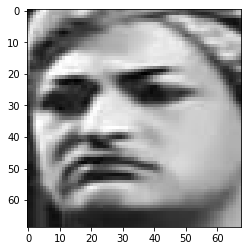

In [0]:
#Lets Visualise a random Image:
img = plt.imread(Train_dir+'Train/0.jpg')
plt.imshow(img)

In [0]:
df = pd.read_csv(Train_dir+'train.csv')
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


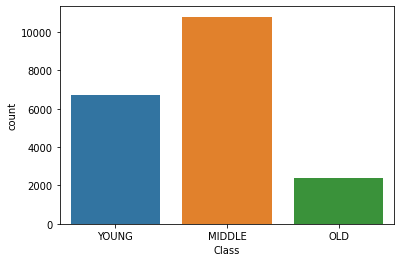

In [0]:
import seaborn as sns
sns.countplot(x = 'Class',data = df, order=['YOUNG','MIDDLE','OLD'])

In [0]:
df['target'] = 1
df_labels = df.pivot('ID','Class', 'target').reset_index().fillna(0)
df_labels.head()

Class,ID,MIDDLE,OLD,YOUNG
0,0.jpg,1.0,0.0,0.0
1,1.jpg,0.0,1.0,0.0
2,100.jpg,1.0,0.0,0.0
3,10000.jpg,1.0,0.0,0.0
4,10001.jpg,0.0,0.0,1.0


In [0]:
#Now we will perform StratifiedKFold with splits=5
skf=StratifiedKFold(n_splits=5,random_state=26,shuffle=True)

In [0]:
#Now lets make split of labels according to Stratified k fold:
Dict={}
for i,(train_idx,val_idx) in enumerate(skf.split(df_labels,df['Class'])):
    Dict['train'+str(i+1)]=df_labels.iloc[train_idx].reset_index().drop('index',axis=1)
    Dict['val'+str(i+1)]=df_labels.iloc[val_idx].reset_index().drop('index',axis=1)
    

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class Age(Dataset):
    
    def __init__(self,df,phase):
        self.phase = phase
        self.df = df
        if phase == 'train':
            self.transforms = aug.Compose([
            aug.Resize(64,64),
            aug.HorizontalFlip(p=0.3),
            aug.RandomBrightnessContrast(0.1,0.1),
            aug.HueSaturationValue(10,10,10),
            aug.RGBShift(),
            aug.ToGray(),
            aug.OneOf([
                aug.RandomContrast(limit=0.2),
                aug.RandomGamma()],p=1),
            aug.ShiftScaleRotate(rotate_limit=(-45,45)),
            aug.OneOf([
                aug.GaussNoise(p=0.35),
                aug.IAASharpen()],p=0.7),
            aug.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ToTensor()
            ])
        elif phase == 'val':
            self.transforms = aug.Compose([
                aug.Resize(64,64),
                aug.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
        elif phase == 'test':
            self.transforms = aug.Compose([
                aug.Resize(64,64),
                aug.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        if self.phase == 'train' or 'val':
            path = Train_dir+'Train/' + str(name)
        if self.phase == 'test':
            path = Test_dir+'Test/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        return img,label

In [0]:
dset={}
for i in range(5):
    dset['train'+str(i+1)]=Age(Dict['train'+str(i+1)],phase='train')
    dset['val'+str(i+1)]=Age(Dict['val'+str(i+1)],phase='val')

In [0]:
Dloader={}
for i in range(5):
    Dloader['d'+str(i+1)]={'train':torch.utils.data.DataLoader(dset['train'+str(i+1)],batch_size=64,shuffle=True,num_workers=4),
                          'val':torch.utils.data.DataLoader(dset['val'+str(i+1)],batch_size=32,shuffle=True,num_workers=4)}

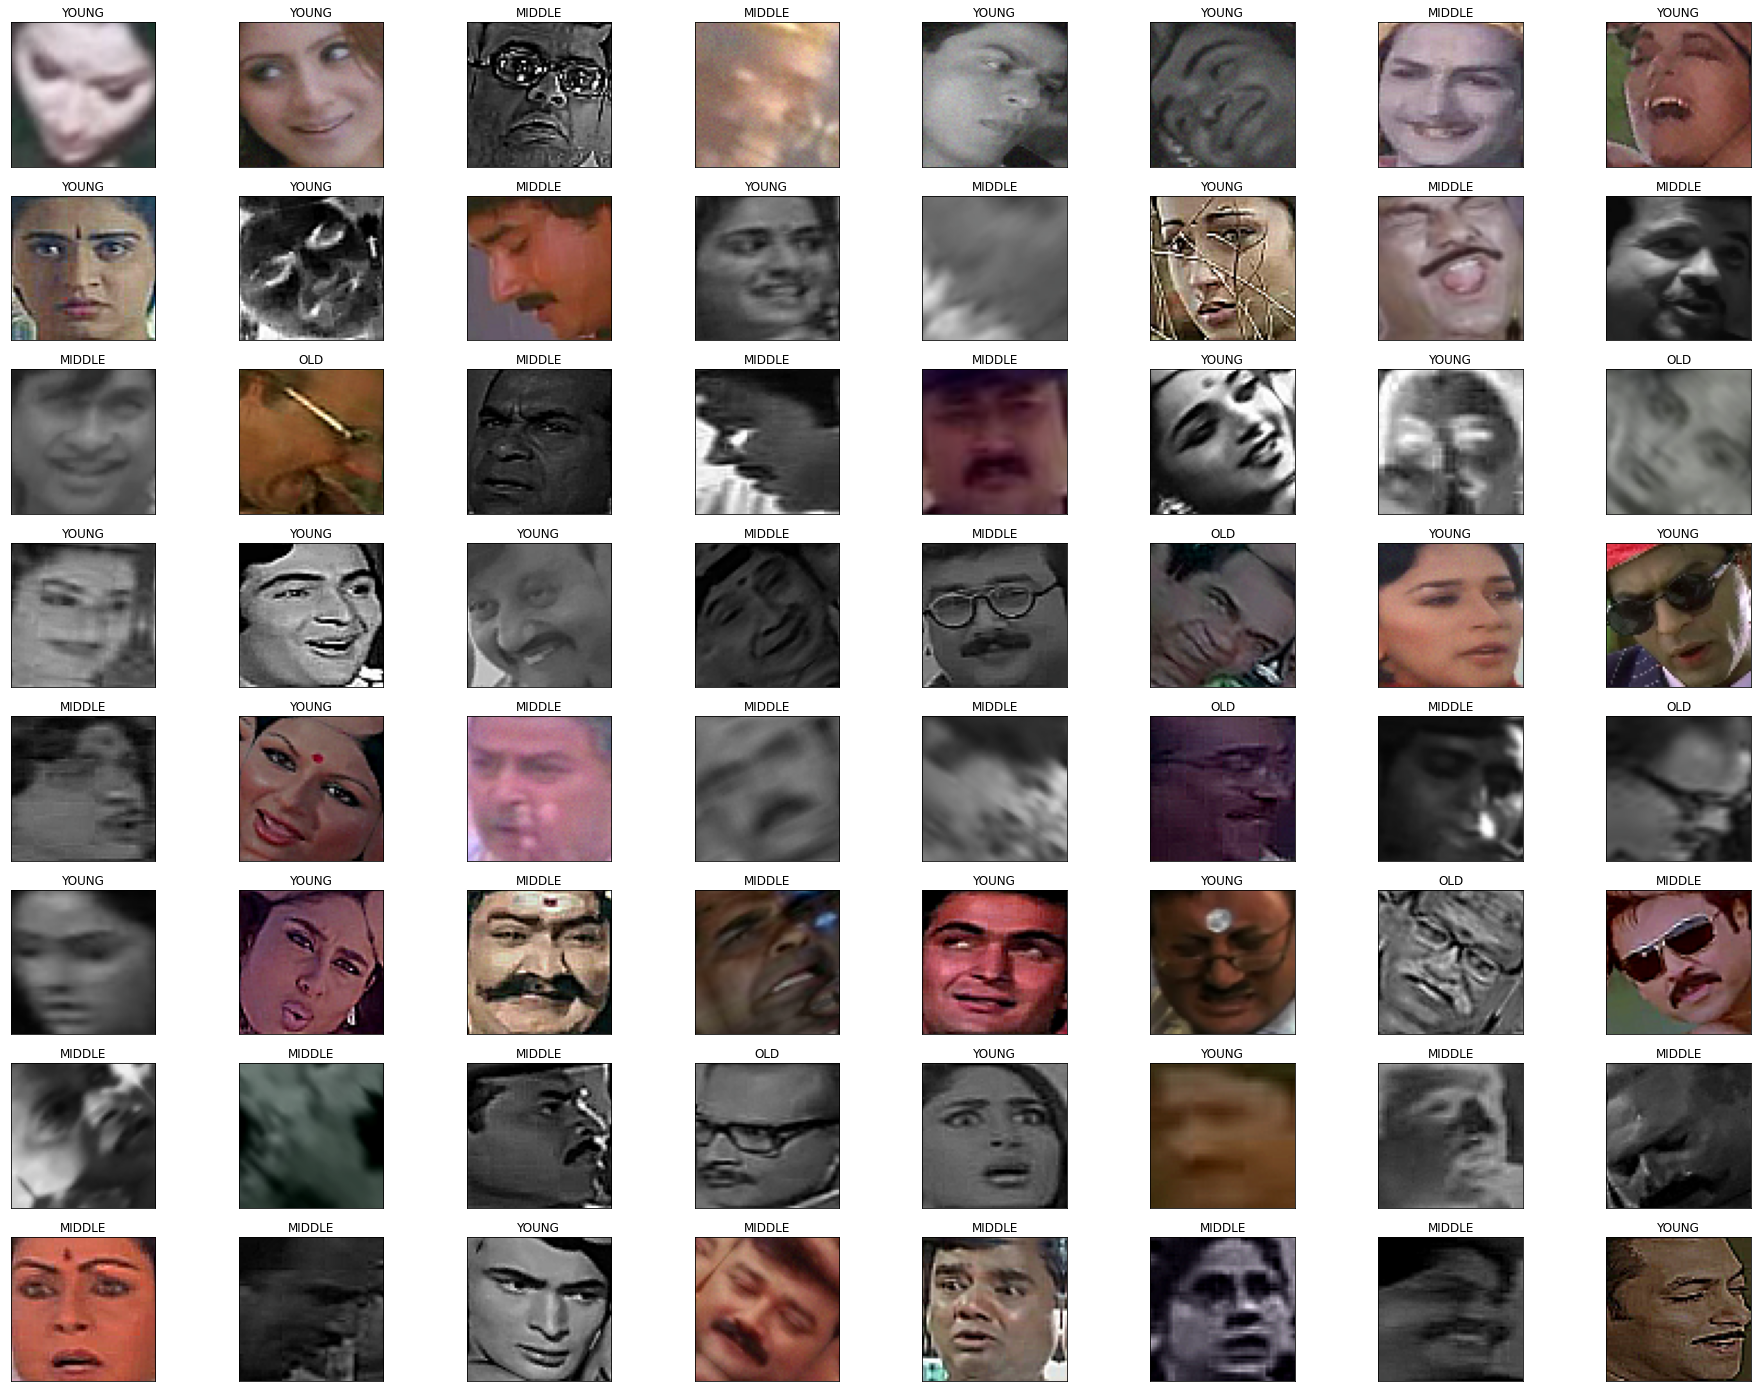

In [0]:
classes = ['MIDDLE','OLD','YOUNG']
#Now lets view our image:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
images,labels=next(iter(Dloader['d1']['train']))
fig = plt.figure(figsize=(32,25))
for i in np.arange(64):
    ax = fig.add_subplot(8,8,i+1,xticks=[],yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

**First freeze the outer layers and train the Fc layer to fine tune**

In [0]:
effnetb3 = timm.create_model('efficientnet_b3',pretrained = True)
effnetb3.to(device);


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


In [0]:
#Now replace the outer layer:
fc_inputs=effnetb3.classifier.in_features
for param in effnetb3.parameters():
    param.requires_grad=False
effnetb3.classifier=nn.Linear(fc_inputs, 3).cuda()

In [0]:
def train_model(part,dataloader, model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = model.state_dict()
    best_acc=0.0
    dataset_sizes = {'train': len(dataloader['train'].dataset), 
                     'val': len(dataloader['val'].dataset)}
          
    for epoch in range(num_epochs):
        for phase in ['train','val']:
            if phase=='train':
                model.train(True)
            else:
                model.train(False)
            running_loss=0.0
            running_correct=0
            for i,(inputs,labels) in enumerate(Bar(dataloader[phase])):
                inputs,labels=Variable(inputs.to(device)),Variable(labels.to(device))
                optimizer.zero_grad()
                outputs=model(inputs)
                _,preds=torch.max(outputs.data,1)
                loss=criterion(outputs,labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()
                running_loss+=(loss.data).item()
                running_correct+=torch.sum(preds==labels.data)
            if phase=='train':
                train_epoch_loss=float(running_loss)/dataset_sizes[phase]
                train_epoch_acc=float(running_correct)/dataset_sizes[phase]
            else:
                valid_epoch_loss=float(running_loss)/dataset_sizes[phase]
                valid_epoch_acc=float(running_correct)/dataset_sizes[phase]
                scheduler.step(valid_epoch_loss)
            
            if phase == 'val' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(),f'/content/drive/My Drive/AgeDetectionFolds/best_weights{part}.pth')
    
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} valid loss: {:.4f} acc: {:.4f}'.format(
          epoch, num_epochs - 1,
          train_epoch_loss, train_epoch_acc, 
          valid_epoch_loss, valid_epoch_acc))
        model.load_state_dict(best_model_wts)  
    return model

**For the initial fine_tune training use Adam,and then ranger with lr=1e-3**

In [0]:
optimizer_b3 = Ranger([parameters for parameters in effnetb3.parameters() if parameters.requires_grad],lr=1e-2)
criterion_b3 = nn.CrossEntropyLoss(weight=torch.FloatTensor([1,0.2217,0.62078]).cuda())
scheduler_b3 = ReduceLROnPlateau(optimizer_b3,factor=0.9, mode="min", patience=3)
effnetb3=train_model(1,Dloader['d1'],effnetb3,criterion_b3,optimizer_b3,scheduler_b3,num_epochs=20)

15924/15924: [===============================>] - ETA 0.8s
3982/3982: [===============================>] - ETA 0.2s
Epoch [0/19] train loss: 0.0121 acc: 0.5495 valid loss: 0.0239 acc: 0.5733
15924/15924: [===============================>] - ETA 0.7s
3982/3982: [===============================>] - ETA 0.3s
Epoch [1/19] train loss: 0.0117 acc: 0.5637 valid loss: 0.0239 acc: 0.5751
15924/15924: [===============================>] - ETA 0.9s
3982/3982: [===============================>] - ETA 0.3s
Epoch [2/19] train loss: 0.0119 acc: 0.5656 valid loss: 0.0257 acc: 0.5495
15924/15924: [===============================>] - ETA 0.9s
3982/3982: [===============================>] - ETA 0.3s
Epoch [3/19] train loss: 0.0120 acc: 0.5586 valid loss: 0.0264 acc: 0.5505
15924/15924: [===============================>] - ETA 0.9s
3982/3982: [===============================>] - ETA 0.2s
Epoch [4/19] train loss: 0.0122 acc: 0.5613 valid loss: 0.0263 acc: 0.5500
15924/15924: [===============================

In [0]:
for param in effnetb3.parameters():
    param.requires_grad=True
optimizer_b3 = Ranger([parameters for parameters in effnetb3.parameters() if parameters.requires_grad],lr=1e-3)
criterion_b3 = nn.CrossEntropyLoss(weight=torch.FloatTensor([1,0.2217,0.62078]).cuda())
scheduler_b3 = ReduceLROnPlateau(optimizer_b3,factor=0.9, mode="min", patience=3)
effnetb3=train_model(1,Dloader['d1'],effnetb3,criterion_b3,optimizer_b3,scheduler_b3,num_epochs=15)

15924/15924: [===============================>] - ETA 1.1s
3982/3982: [===============================>] - ETA 0.3s
Epoch [0/14] train loss: 0.0112 acc: 0.5787 valid loss: 0.0208 acc: 0.6268
15924/15924: [===============================>] - ETA 1.1s
3982/3982: [===============================>] - ETA 0.2s
Epoch [1/14] train loss: 0.0100 acc: 0.6212 valid loss: 0.0188 acc: 0.6690
15924/15924: [===============================>] - ETA 1.3s
3982/3982: [===============================>] - ETA 0.3s
Epoch [2/14] train loss: 0.0089 acc: 0.6601 valid loss: 0.0164 acc: 0.7022
15924/15924: [===============================>] - ETA 1.3s
3982/3982: [===============================>] - ETA 0.2s
Epoch [3/14] train loss: 0.0082 acc: 0.6915 valid loss: 0.0146 acc: 0.7230
15924/15924: [===============================>] - ETA 1.2s
3982/3982: [===============================>] - ETA 0.3s
Epoch [4/14] train loss: 0.0075 acc: 0.7183 valid loss: 0.0133 acc: 0.7564
15924/15924: [===============================

**Now lets get our Predictions on Test Set....**

In [0]:
sample = pd.read_csv('sample_submission.csv')
output = pd.DataFrame(index = sample.index,columns = sample.keys())
output['ID'] = sample['ID']
sample = sample[["ID","Class"]]
sample.head()
testdata = Age(sample,'test')
testloader = torch.utils.data.DataLoader(testdata,batch_size = 32)
def test_submission(model):
    since = time.time()
    sub_output = []
    model.train(False)
    for data in testloader:
        inputs,labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        pred = pred.data.cpu().numpy()
        sub_output.append(pred.data)
    sub_output = np.concatenate(sub_output)
    output['Class'] = sub_output
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
test_submission(effnetb3)
d = {2:'YOUNG',0:'MIDDLE',1:'OLD'}
output['Class'] = output['Class'].map(d)
output.head()
output.to_csv('res.csv',index=False)



Run complete in 0m 12s
